In [1]:
import pickle as pc
import numpy as np
import matplotlib.pyplot as pp
import processing
import scipy.optimize as so
import pandas as pd

import warnings

# Suppress all UserWarnings
warnings.simplefilter(action='ignore', category=UserWarning)

processing.DenormalizedSimulation

pickle_path = '/home/jachym/SPICEdata/EmxwPTe.pickle'
pickle_path2 = '/home/jachym/SPICEdata/EmxwrectP.pickle'
pickle_path3 = '/home/jachym/SPICEdata/EmxwsqP.pickle'
pickle_path4 = '/home/jachym/SPICEdata/EmxwrsqP.pickle'
with open(pickle_path, 'rb') as f:
    data = pc.load(f)
with open(pickle_path2, 'rb') as f:
    dataR = pc.load(f)
with open(pickle_path3, 'rb') as f:
    dataS = pc.load(f)
with open(pickle_path4, 'rb') as f:
    dataRS = pc.load(f)
dfC = pd.read_csv('probe_widths.csv', sep=';')
dfR = pd.read_csv('probe_widthsR.csv', sep=';')
dfS = pd.read_csv('probe_widthsS.csv', sep=';')

In [2]:
def process_data(data):
    KtoeV = 8.617e-5
    df = pd.DataFrame(columns=['Ie', 'Ii', 'IPfluxe', 'IPfluxi', 'pot', 'Te', 'B', 'G01', 'G02', 'G03', 'G04'])
    i = 0
    for d in data:
        df.loc[i] = [d['Ie'], d['Ii'], d['IPfluxe'], d['IPfluxi'], d['pot'], round(d['Te']*KtoeV,1), d['B'], d['G01'], d['G02'], d['G03'], d['G04']]
        i += 1
    df['I'] = df['Ie']+df['Ii']
    df['IPflux'] = df['IPfluxi']+df['IPfluxe']
    return df

In [3]:
circleProbeDF = process_data(data)
rectProbeDF = process_data(dataR)
squareProbeDF = process_data(dataS)
RsquareProbeDF = process_data(dataRS)

In [4]:
def upper_lower_flux(Garray):
    return np.sum(Garray[len(Garray[0])//2+1:, :]), np.sum(Garray[0:len(Garray[0])//2+1, :])

In [5]:
def fill_up_low(df, uldf):
    i = 0
    for Te in df['Te'].unique():
        pots = df[df['Te'] == Te]['pot']
        for pot in pots:
            upperG1, lowerG1 = upper_lower_flux(df[df['Te']==Te][df['pot']==pot]['G01'].values[0])
            upperG3, lowerG3 = upper_lower_flux(df[df['Te']==Te][df['pot']==pot]['G03'].values[0])
            uldf.loc[i] = [Te, pot, upperG1, lowerG1, upperG3, lowerG3]
            i+=1
    uldf.sort_values(by=['Te', 'pot'], inplace=True)
    return uldf

In [6]:
ULDFC = pd.DataFrame(columns=['Te', 'pot', 'Gu1', 'Gl1', 'Gu3', 'Gl3'])
ULDFR = pd.DataFrame(columns=['Te', 'pot', 'Gu1', 'Gl1', 'Gu3', 'Gl3'])
ULDFS = pd.DataFrame(columns=['Te', 'pot', 'Gu1', 'Gl1', 'Gu3', 'Gl3'])
ULDFRS = pd.DataFrame(columns=['Te', 'pot', 'Gu1', 'Gl1', 'Gu3', 'Gl3'])

ULDFC = fill_up_low(circleProbeDF, ULDFC)
ULDFR = fill_up_low(rectProbeDF, ULDFR)
ULDFS = fill_up_low(squareProbeDF, ULDFS)
ULDFRS = fill_up_low(RsquareProbeDF, ULDFRS)

In [7]:
markers = ['v', 'o', '^', '<', '>', 's', 'p', 'P', '*', 'h', 'H', 'X', 'D', 'd']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
linestyles = ['-', '--', '-.', ':']

In [8]:
def flux_compare(particle_type):
    for Te, i in zip(circleProbeDF['Te'].unique(), range(0, len(circleProbeDF['Te'].unique()))):
        pp.plot(ULDFC[ULDFC['Te']==Te]['pot'], ULDFC[ULDFC['Te']==Te][f'Gu{particle_type}'], 
                label=f'circle upper Te = {Te}', marker=markers[i], color='tab:blue', linestyle=linestyles[0])
        pp.plot(ULDFC[ULDFC['Te']==Te]['pot'], ULDFC[ULDFC['Te']==Te][f'Gl{particle_type}'], 
                label=f'circle lower Te = {Te}', marker=markers[i], color='tab:blue', linestyle=linestyles[1])

    for Te, i in zip(rectProbeDF['Te'].unique(), range(0, len(rectProbeDF['Te'].unique()))):
        pp.plot(ULDFR[ULDFR['Te']==Te]['pot'], ULDFR[ULDFR['Te']==Te][f'Gu{particle_type}'], 
                label=f'rectangle upper Te = {Te}', marker=markers[i], color='tab:red', linestyle=linestyles[0])
        pp.plot(ULDFR[ULDFR['Te']==Te]['pot'], ULDFR[ULDFR['Te']==Te][f'Gl{particle_type}'], 
                label=f'rectangle lower Te = {Te}', marker=markers[i], color='tab:red', linestyle=linestyles[1])

    for Te, i in zip(squareProbeDF['Te'].unique(), range(0, len(squareProbeDF['Te'].unique()))):
        pp.plot(ULDFS[ULDFS['Te']==Te]['pot'], ULDFS[ULDFS['Te']==Te][f'Gu{particle_type}'], 
                label=f'square upper Te = {Te}', marker=markers[i], color='tab:green', linestyle=linestyles[0])
        pp.plot(ULDFS[ULDFS['Te']==Te]['pot'], ULDFS[ULDFS['Te']==Te][f'Gl{particle_type}'], 
                label=f'square lower Te = {Te}', marker=markers[i], color='tab:green', linestyle=linestyles[1])

    for Te, i in zip(squareProbeDF['Te'].unique(), range(0, len(squareProbeDF['Te'].unique()))):
        pp.plot(ULDFRS[ULDFRS['Te']==Te]['pot'], ULDFRS[ULDFRS['Te']==Te][f'Gu{particle_type}'], 
                label=f'rotated square upper Te = {Te}', marker=markers[i], color='tab:purple', linestyle=linestyles[0])
        pp.plot(ULDFRS[ULDFRS['Te']==Te]['pot'], ULDFRS[ULDFRS['Te']==Te][f'Gl{particle_type}'], 
                label=f'rotated square lower Te = {Te}', marker=markers[i], color='tab:purple', linestyle=linestyles[1])

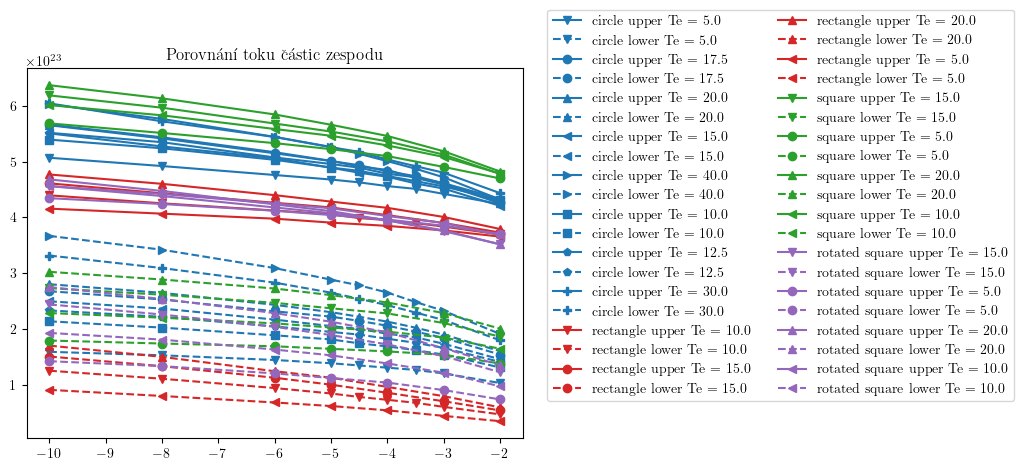

In [9]:
flux_compare('1')
pp.title('Porovnání toku částic zespodu')
pp.legend(ncol=2, loc=(1.05,0.1))

Text(0.5, 1.0, 'Porovnání toku částic zhora')

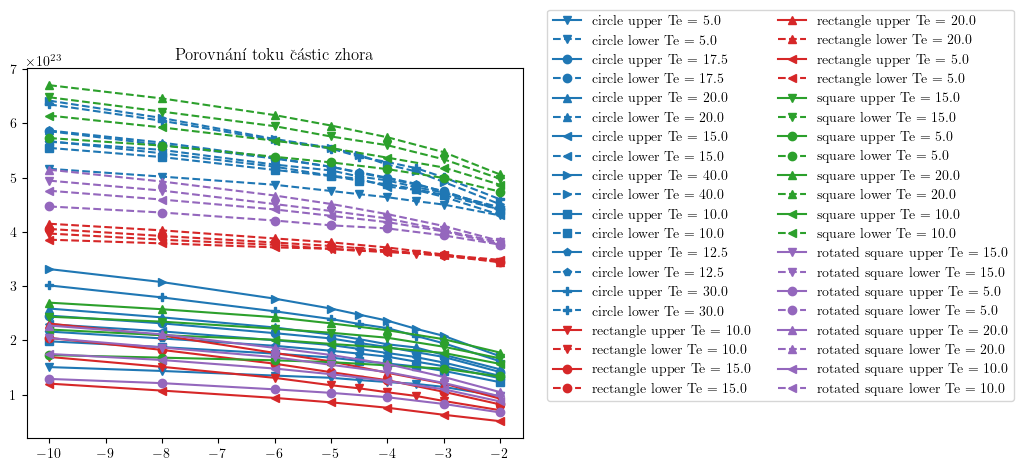

In [10]:
flux_compare('3')
pp.legend(ncol=2, loc=(1.05,0.1))
pp.title('Porovnání toku částic zhora')

In [11]:
pots = ULDFS['pot'].unique()

In [12]:
def compare_upper_lower(df1, df2, title):
    smaller = []
    if len(df1['Te'].unique()) > len(df2['Te'].unique()):
        smaller = df2
    else:
        smaller = df1
    for Te, i in zip(smaller['Te'].unique(), range(len(smaller['Te'].unique()))):
        pp.plot(pots, df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gu1'].values/df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gu1'].values,
                label=f'dominantní tok zhora Te = {Te}', marker=markers[0], color='tab:blue', linestyle=linestyles[i])
        pp.plot(pots, df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gl3'].values/df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gl3'].values,
            label=f'dominantní tok zespodu Te = {Te}', marker=markers[11], color='tab:blue', linestyle=linestyles[i])
        pp.plot(pots, df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gl1'].values/df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gl1'].values,
                label=f'zpětný tok zhora Te = {Te}', marker=markers[0], color='tab:red', linestyle=linestyles[i])
        pp.plot(pots, df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gu3'].values/df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gu3'].values,
            label=f'zpětný tok zespodu Te = {Te}', marker=markers[11], color='tab:red', linestyle=linestyles[i])
    pp.legend(loc = (1.05, 0.1))
    pp.title(title)
    pp.show()

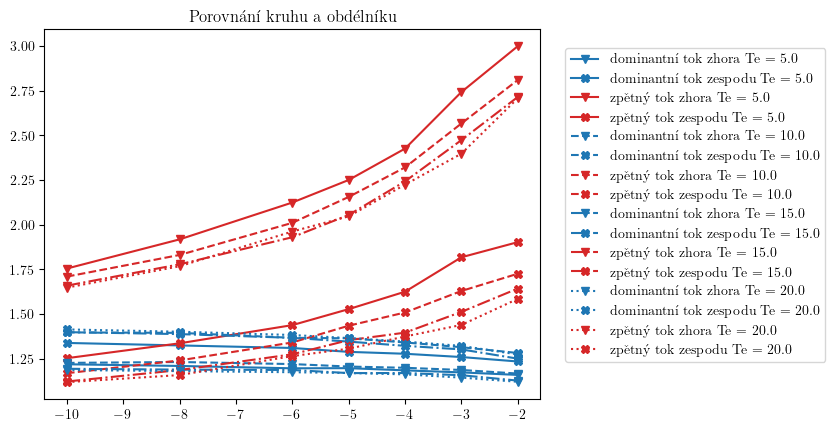

In [13]:
compare_upper_lower(ULDFC, ULDFR, "Porovnání kruhu a obdélníku")

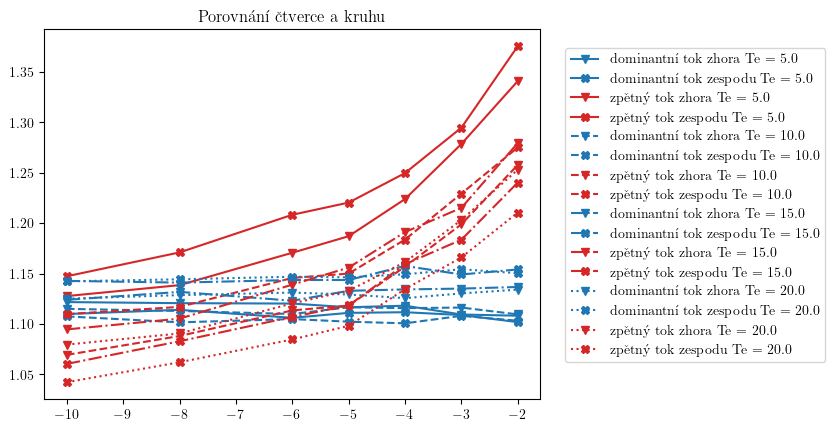

In [14]:
compare_upper_lower(ULDFS, ULDFC, "Porovnání čtverce a kruhu")

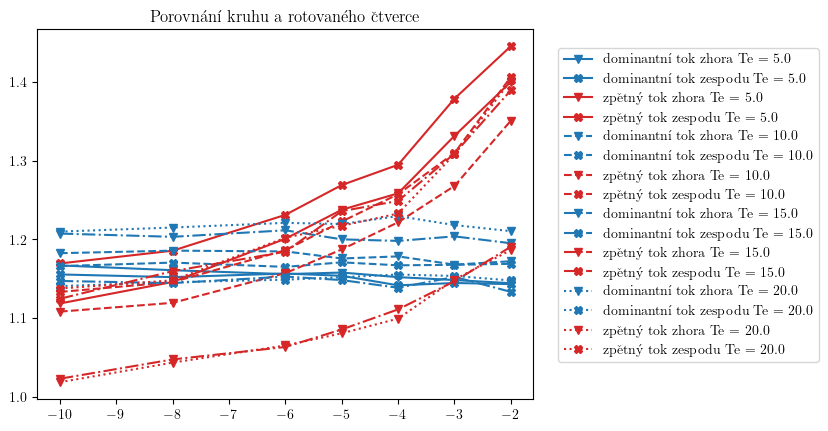

In [15]:
compare_upper_lower(ULDFC, ULDFRS, "Porovnání kruhu a rotovaného čtverce")

In [16]:
def compare_upper_lower_Te(df, title):
    for pot, i in zip(df['pot'].unique(), range(len(df['pot'].unique()))):
        pp.plot(df[df['pot']==pot]['Te'], df[df['pot']==pot]['Gu1'].values/df[df['pot']==pot]['Gl1'].values,
                label=f'zhora pot = {pot}', marker=markers[i], color='tab:blue', linestyle='solid')
        pp.plot(df[df['pot']==pot]['Te'], df[df['pot']==pot]['Gl3'].values/df[df['pot']==pot]['Gu3'].values,
                label=f'zespodu pot = {pot}', marker=markers[i], color='tab:red', linestyle='solid')
    pp.legend(loc = (1.05, 0.1))
    pp.title(title)

In [17]:
def weight_n(value):
    demo_n = np.array([0.22547000546621856, 0.227715270710718, 0.22728509532699537, 0.22487725322786856, 0.22377045445794996, 0.22255486400262328, 0.224033043706334, 0.22706660393048067, 0.2240372056901537, 0.224985849269943, 0.23008814853550824, 0.2232078383602904, 0.2233344508612799, 0.22761672316940795, 0.22579746546949117, 0.22773770530886264, 0.22590547409120612, 0.23261096826364674, 0.23446014582933225, 0.2424065630351785, 0.2505948475386842, 0.25994246402025295, 0.2696299712303888, 0.27958068885059084, 0.29183712007267143, 0.297540854155711, 0.29820274175320605, 0.30581259277993156, 0.30900153454013646, 0.3101727856161509, 0.30778742088731476, 0.3079620371382223, 0.3039884105001202, 0.30411547961104096, 0.3069037781184309, 0.30581348804671504, 0.3080436290684099, 0.3082947790271649, 0.30846885487651576, 0.30711464986990683, 0.3095942508747972, 0.30708730957489816, 0.3048183024603158, 0.3041952371641684, 0.30694193362366995, 0.3090430588872994, 0.30760927465831667, 0.30560127284040717, 0.3066232220532096, 0.3032127639113321, 0.30270374678329254, 0.30512618813518083, 0.3088061084440573, 0.31267197652356205, 0.3087161191040908, 0.3123841127041433, 0.30901450173877215, 0.30867323709633926, 0.3023865880711992, 0.3092379227544499, 0.31132879579629885, 0.30675477151147246, 0.3060555085185024, 0.30575809417609023, 0.3103030465397623, 0.3110413495305344, 0.3065874151452213, 0.3099377650556447, 0.3194213087920771, 0.31405065108825214, 0.31182858027581084, 0.31503544723678556, 0.3130277260664859, 0.31541512442309383, 0.31610154581038347, 0.3187622569730991, 0.3176386498077813, 0.31864620789764775, 0.3192635935083194, 0.319600664197075, 0.3196327245443441, 0.324372153207809, 0.3246223755697618, 0.3244614679133736, 0.3264292773676262, 0.32557289702476555, 0.32739502408574767, 0.32820591183170655, 0.3254898017842842, 0.3283178574634086, 0.3282546257579103, 0.3302730929397986, 0.3317567147866109, 0.32625257200759655, 0.32825538893349926, 0.32646249705944946, 0.32769877717699836, 0.3283483697289667, 0.33289569118404755, 0.3311383689114879, 0.3335686546567257, 0.3321332065236019, 0.33489987890124095, 0.3347577111834199, 0.3385208081736754, 0.34011660554564044, 0.33380395118244904, 0.32862696194323854, 0.3372804204966829, 0.33915758808044066, 0.3419415542504989, 0.34012368452432756, 0.3403425387339683, 0.3336299155496866, 0.33576892627055965, 0.3354874584965779, 0.33502984080413173, 0.3366557039532619, 0.3388312333626388, 0.3387371104567651, 0.33894535530059794, 0.3440091819865008, 0.34476071982901385, 0.3434905053850273, 0.3451615122586962, 0.34416606166228875, 0.3428955656756431, 0.34143586924690233, 0.34412968319483295, 0.3412213962228599, 0.34251648948372304, 0.34802067718308366, 0.3416261398299661, 0.34495948151306643, 0.34483964939300404, 0.3452947802886023, 0.3419984409400564, 0.34918764806557573, 0.3469211911486946, 0.34859617841434665, 0.353269014797382, 0.35162569420766837, 0.34598689683002476, 0.3472404907566251, 0.3459690083112319, 0.34797536188166045, 0.3526495619829128, 0.35045911219199, 0.3472556825336488, 0.34973272438390846, 0.35134180127420356, 0.3481938718559716, 0.3502312240500871, 0.35312860531427914, 0.3503786719456823, 0.3474946428813682, 0.3486742068862739, 0.35481555810804716, 0.3469941669457969, 0.34559282764195737, 0.3530627354926781, 0.3490124224859943, 0.3476552486405508, 0.3492311269282657, 0.3481775119672208, 0.3454120123219951, 0.34460017844462554, 0.34613020570830655, 0.34861111516934223, 0.34898170008587076, 0.35059256378843895, 0.35530357646306426, 0.3530094566389681, 0.34763934149950065, 0.35172566464295946, 0.3477068705532287, 0.3459995491541492, 0.3466261564560411, 0.3449925848838041])
    return value*np.mean(demo_n[:value])/np.mean(demo_n)

def compare_widths_pot(df, pots, plot_errorbars=False):
    for pot, i in zip(pots, range(len(pots))):
        dfm2 = df[df['Voltage'].eq(pot) & df['Type'].eq(-2)]
        dfm1 = df[df['Voltage'].eq(pot) & df['Type'].eq(-1)]
        dfm2.sort_values('Te', inplace=True)
        dfm1.sort_values('Te', inplace=True)
        weightedm2 = np.array([weight_n(i) for i in dfm2['Width'].values])
        weightedm1 = np.array([weight_n(i) for i in dfm1['Width'].values])
        diff = weightedm1 - weightedm2
        pp.plot(dfm2['Te'], weightedm1/diff, label=f'zhora pot = {pot}', marker=markers[i], color='tab:green', linestyle='solid')
        if plot_errorbars: pp.errorbar(dfm2['Te'], weightedm1/diff, yerr=(weightedm1+1)/(diff-1), fmt='.', color='tab:green', capsize=5.0)
        dfm2 = df[df['Voltage'].eq(pot) & df['Type'].eq(2)]
        dfm1 = df[df['Voltage'].eq(pot) & df['Type'].eq(1)]
        dfm2.sort_values('Te', inplace=True)
        dfm1.sort_values('Te', inplace=True)
        weightedm2 = np.array([weight_n(i) for i in dfm2['Width'].values])
        weightedm1 = np.array([weight_n(i) for i in dfm1['Width'].values])
        diff = weightedm1 - weightedm2
        pp.plot(dfm2['Te'], weightedm1/diff, label=f'zespodu pot = {pot}', marker=markers[i], color='tab:orange', linestyle='solid')
        if plot_errorbars: pp.errorbar(dfm2['Te'], weightedm1/diff, yerr=(weightedm1+1)/(diff-1), fmt='.', color='tab:orange', capsize=5.0)

/tmp/ipykernel_127044/2892104463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Te', inplace=True)
/tmp/ipykernel_127044/2892104463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm1.sort_values('Te', inplace=True)
/tmp/ipykernel_127044/2892104463.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Te', inplace=True)
/tmp/ipykernel_127044/2892104463.py:19: SettingWithCopyWarning: 
A valu

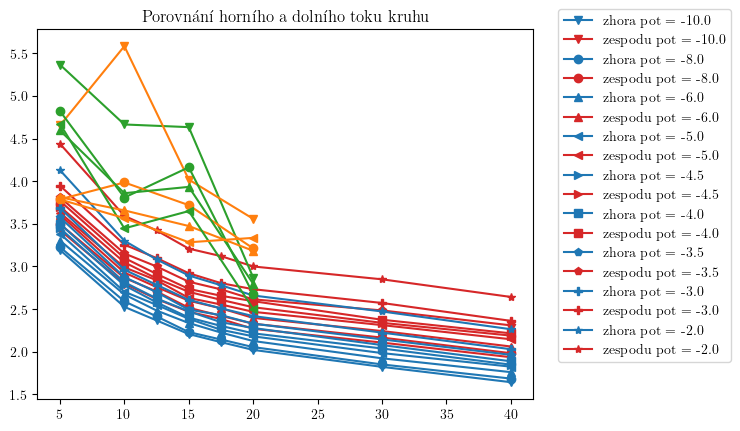

In [18]:
compare_upper_lower_Te(ULDFC, "Porovnání horního a dolního toku kruhu")
compare_widths_pot(dfC, [-2,-4,-6,-10])

/tmp/ipykernel_127044/2892104463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Te', inplace=True)
/tmp/ipykernel_127044/2892104463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm1.sort_values('Te', inplace=True)
/tmp/ipykernel_127044/2892104463.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Te', inplace=True)
/tmp/ipykernel_127044/2892104463.py:19: SettingWithCopyWarning: 
A valu

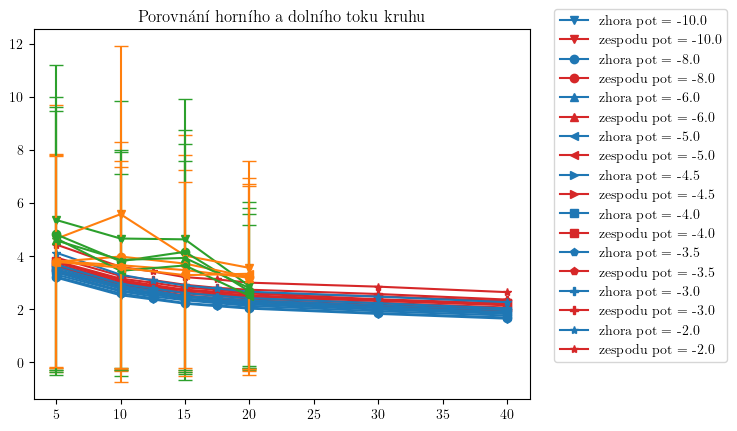

In [19]:
compare_upper_lower_Te(ULDFC, "Porovnání horního a dolního toku kruhu")
compare_widths_pot(dfC, [-2,-4,-6,-10], plot_errorbars=True)

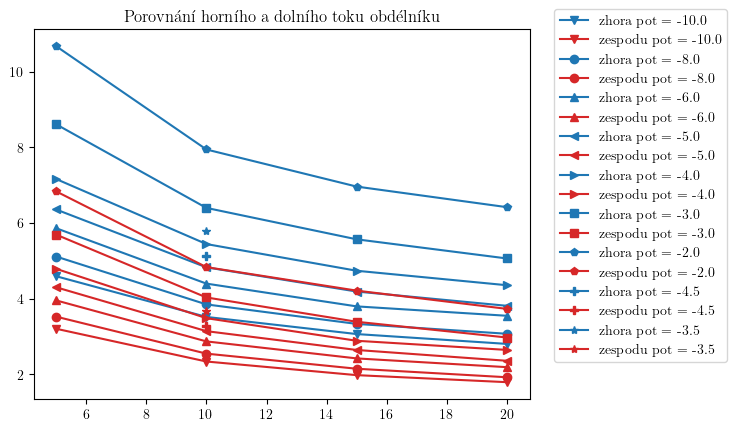

In [20]:
compare_upper_lower_Te(ULDFR, "Porovnání horního a dolního toku obdélníku")

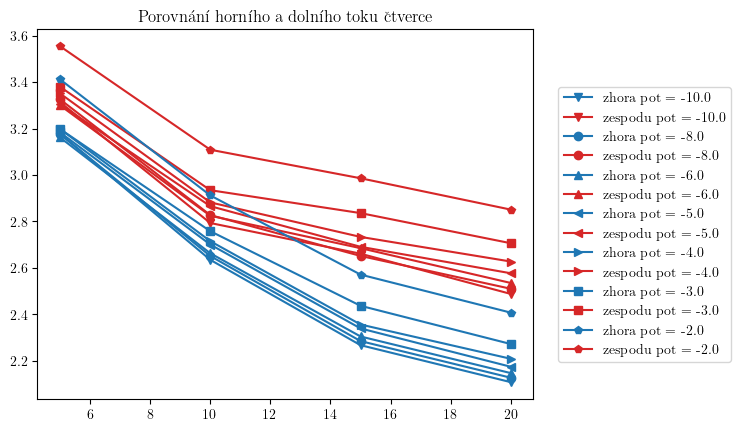

In [21]:
compare_upper_lower_Te(ULDFS, "Porovnání horního a dolního toku čtverce")

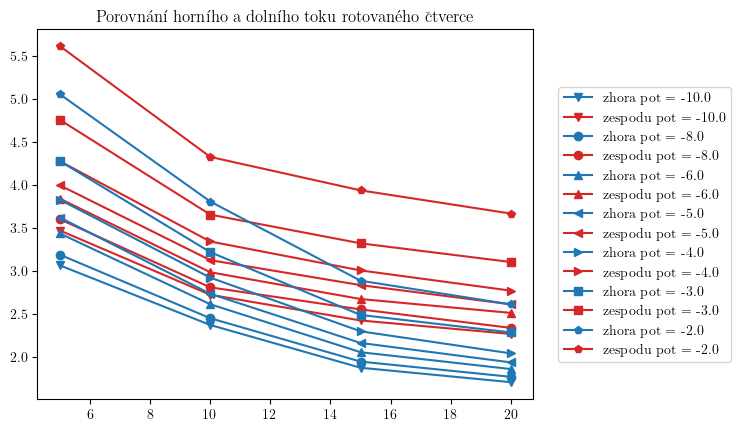

In [22]:
compare_upper_lower_Te(ULDFRS, "Porovnání horního a dolního toku rotovaného čtverce")

In [23]:
def compare_upper_lower_one(df, title):
    for Te, i in zip(df['Te'].unique(), range(len(df['Te'].unique()))):
        pp.plot(pots, df[df['Te']==Te][df['pot'].isin(pots)]['Gu1'].values/df[df['Te']==Te][df['pot'].isin(pots)]['Gl1'].values,
                label=f'zhora Te = {Te}', marker=markers[i], color='tab:blue', linestyle='solid')
        pp.plot(pots, df[df['Te']==Te][df['pot'].isin(pots)]['Gl3'].values/df[df['Te']==Te][df['pot'].isin(pots)]['Gu3'].values,
            label=f'zespodu Te = {Te}', marker=markers[i], color='tab:red', linestyle='solid')
    pp.legend(loc = (1.05, 0.1))
    pp.title(title)

In [82]:
def weight_n(value):
    demo_n = np.array([0.22547000546621856, 0.227715270710718, 0.22728509532699537, 0.22487725322786856, 0.22377045445794996, 0.22255486400262328, 0.224033043706334, 0.22706660393048067, 0.2240372056901537, 0.224985849269943, 0.23008814853550824, 0.2232078383602904, 0.2233344508612799, 0.22761672316940795, 0.22579746546949117, 0.22773770530886264, 0.22590547409120612, 0.23261096826364674, 0.23446014582933225, 0.2424065630351785, 0.2505948475386842, 0.25994246402025295, 0.2696299712303888, 0.27958068885059084, 0.29183712007267143, 0.297540854155711, 0.29820274175320605, 0.30581259277993156, 0.30900153454013646, 0.3101727856161509, 0.30778742088731476, 0.3079620371382223, 0.3039884105001202, 0.30411547961104096, 0.3069037781184309, 0.30581348804671504, 0.3080436290684099, 0.3082947790271649, 0.30846885487651576, 0.30711464986990683, 0.3095942508747972, 0.30708730957489816, 0.3048183024603158, 0.3041952371641684, 0.30694193362366995, 0.3090430588872994, 0.30760927465831667, 0.30560127284040717, 0.3066232220532096, 0.3032127639113321, 0.30270374678329254, 0.30512618813518083, 0.3088061084440573, 0.31267197652356205, 0.3087161191040908, 0.3123841127041433, 0.30901450173877215, 0.30867323709633926, 0.3023865880711992, 0.3092379227544499, 0.31132879579629885, 0.30675477151147246, 0.3060555085185024, 0.30575809417609023, 0.3103030465397623, 0.3110413495305344, 0.3065874151452213, 0.3099377650556447, 0.3194213087920771, 0.31405065108825214, 0.31182858027581084, 0.31503544723678556, 0.3130277260664859, 0.31541512442309383, 0.31610154581038347, 0.3187622569730991, 0.3176386498077813, 0.31864620789764775, 0.3192635935083194, 0.319600664197075, 0.3196327245443441, 0.324372153207809, 0.3246223755697618, 0.3244614679133736, 0.3264292773676262, 0.32557289702476555, 0.32739502408574767, 0.32820591183170655, 0.3254898017842842, 0.3283178574634086, 0.3282546257579103, 0.3302730929397986, 0.3317567147866109, 0.32625257200759655, 0.32825538893349926, 0.32646249705944946, 0.32769877717699836, 0.3283483697289667, 0.33289569118404755, 0.3311383689114879, 0.3335686546567257, 0.3321332065236019, 0.33489987890124095, 0.3347577111834199, 0.3385208081736754, 0.34011660554564044, 0.33380395118244904, 0.32862696194323854, 0.3372804204966829, 0.33915758808044066, 0.3419415542504989, 0.34012368452432756, 0.3403425387339683, 0.3336299155496866, 0.33576892627055965, 0.3354874584965779, 0.33502984080413173, 0.3366557039532619, 0.3388312333626388, 0.3387371104567651, 0.33894535530059794, 0.3440091819865008, 0.34476071982901385, 0.3434905053850273, 0.3451615122586962, 0.34416606166228875, 0.3428955656756431, 0.34143586924690233, 0.34412968319483295, 0.3412213962228599, 0.34251648948372304, 0.34802067718308366, 0.3416261398299661, 0.34495948151306643, 0.34483964939300404, 0.3452947802886023, 0.3419984409400564, 0.34918764806557573, 0.3469211911486946, 0.34859617841434665, 0.353269014797382, 0.35162569420766837, 0.34598689683002476, 0.3472404907566251, 0.3459690083112319, 0.34797536188166045, 0.3526495619829128, 0.35045911219199, 0.3472556825336488, 0.34973272438390846, 0.35134180127420356, 0.3481938718559716, 0.3502312240500871, 0.35312860531427914, 0.3503786719456823, 0.3474946428813682, 0.3486742068862739, 0.35481555810804716, 0.3469941669457969, 0.34559282764195737, 0.3530627354926781, 0.3490124224859943, 0.3476552486405508, 0.3492311269282657, 0.3481775119672208, 0.3454120123219951, 0.34460017844462554, 0.34613020570830655, 0.34861111516934223, 0.34898170008587076, 0.35059256378843895, 0.35530357646306426, 0.3530094566389681, 0.34763934149950065, 0.35172566464295946, 0.3477068705532287, 0.3459995491541492, 0.3466261564560411, 0.3449925848838041])
    return value*np.mean(demo_n[:value])/np.mean(demo_n)

def compare_widths(df, Tes, plot_errorbars=False):
    for Te, i in zip(Tes, range(len(Tes))):
        dfm2 = df[df['Te'].eq(Te) & df['Type'].eq(-2)]
        dfm1 = df[df['Te'].eq(Te) & df['Type'].eq(-1)]
        dfm2.sort_values('Voltage', inplace=True)
        dfm1.sort_values('Voltage', inplace=True)
        weightedm2 = np.array([weight_n(i) for i in dfm2['Width'].values])
        weightedm1 = np.array([weight_n(i) for i in dfm1['Width'].values])
        diff = weightedm1 - weightedm2
        pp.plot(dfm2['Voltage'], weightedm1/diff, label=f'zhora Te = {Te}', marker=markers[i], color='tab:green', linestyle='solid')
        if plot_errorbars: pp.errorbar(dfm2['Voltage'], weightedm1/diff, yerr=np.abs((weightedm1+1)/(diff-1)), fmt='.', color='tab:green', capsize=5.0)
        dfm2 = df[df['Te'].eq(Te) & df['Type'].eq(2)]
        dfm1 = df[df['Te'].eq(Te) & df['Type'].eq(1)]
        dfm2.sort_values('Voltage', inplace=True)
        dfm1.sort_values('Voltage', inplace=True)
        weightedm2 = np.array([weight_n(i) for i in dfm2['Width'].values])
        weightedm1 = np.array([weight_n(i) for i in dfm1['Width'].values])
        diff = weightedm1 - weightedm2
        pp.plot(dfm2['Voltage'], weightedm1/diff, label=f'zespodu Te = {Te}', marker=markers[i], color='tab:orange', linestyle='solid')
        if plot_errorbars: pp.errorbar(dfm2['Voltage'], weightedm1/diff, yerr=np.abs((weightedm1+1)/(diff-1)), fmt='.', color='tab:orange', capsize=5.0)
        pp.legend(loc = (1.05, 0.1))

/tmp/ipykernel_127044/4153650680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/4153650680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm1.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/4153650680.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/4153650680.py:19: SettingWithCopyW

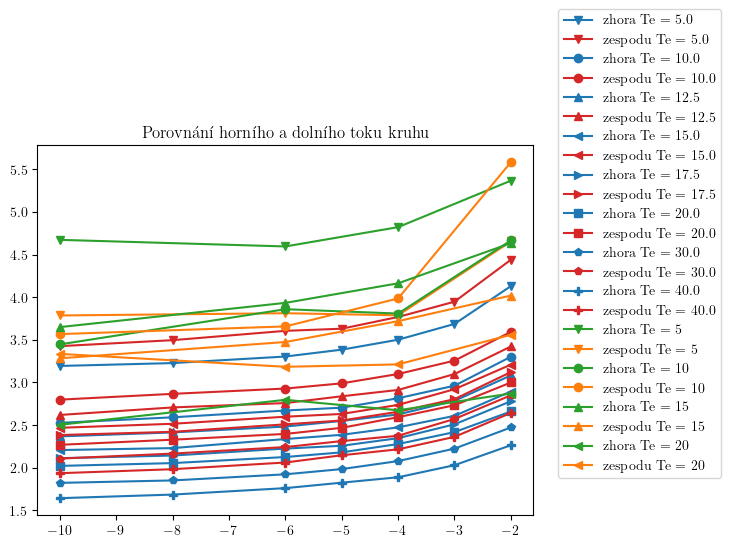

In [83]:
compare_upper_lower_one(ULDFC, "Porovnání horního a dolního toku kruhu")
compare_widths(dfC, [5, 10, 15, 20])

/tmp/ipykernel_127044/4153650680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/4153650680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm1.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/4153650680.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/4153650680.py:19: SettingWithCopyW

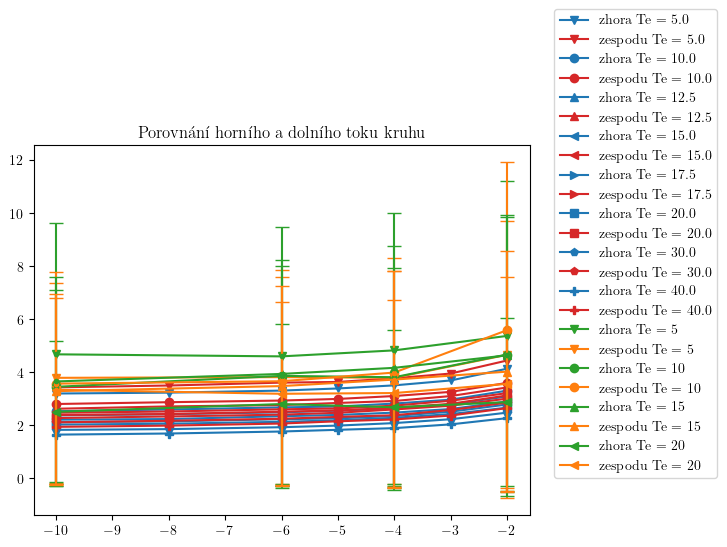

In [84]:
compare_upper_lower_one(ULDFC, "Porovnání horního a dolního toku kruhu")
compare_widths(dfC, [5, 10, 15, 20], plot_errorbars=True)

/tmp/ipykernel_127044/4153650680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/4153650680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm1.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/4153650680.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/4153650680.py:19: SettingWithCopyW

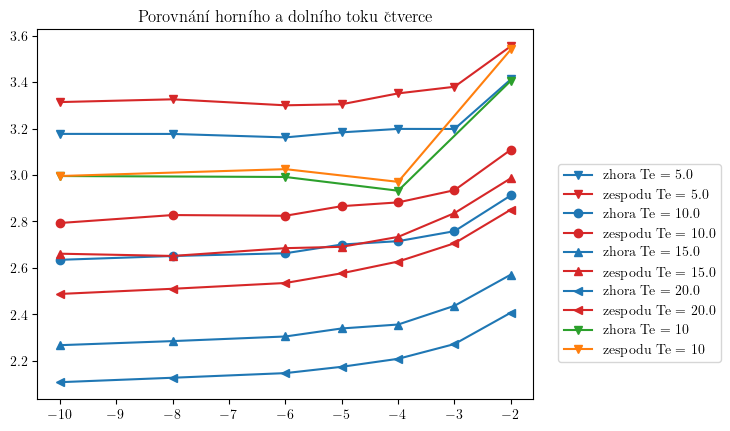

In [85]:
compare_upper_lower_one(ULDFS, "Porovnání horního a dolního toku čtverce")
compare_widths(dfS, [10])

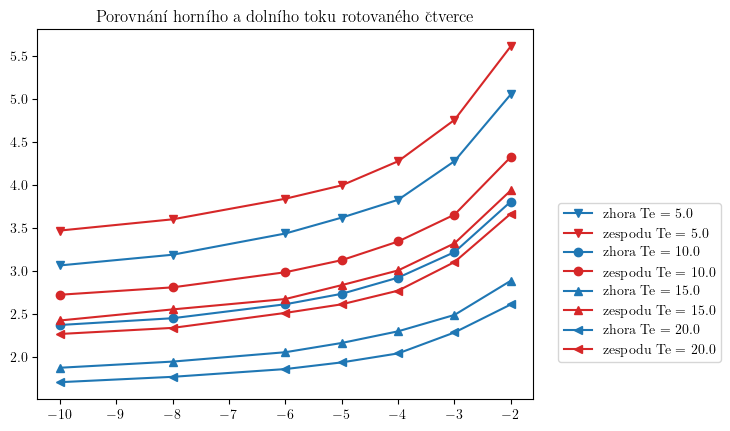

In [86]:
compare_upper_lower_one(ULDFRS, "Porovnání horního a dolního toku rotovaného čtverce")

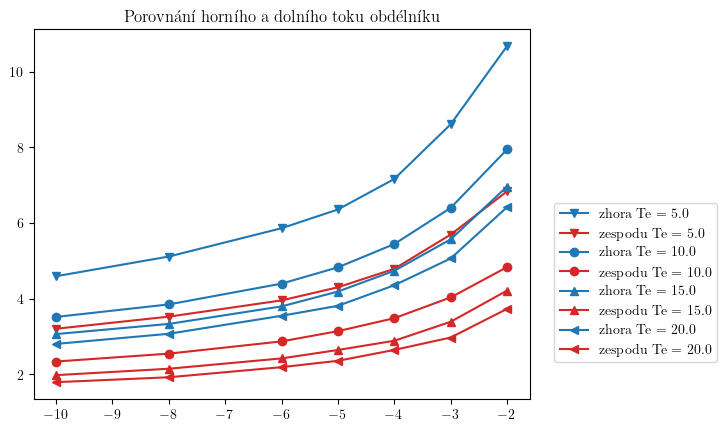

In [100]:
compare_upper_lower_one(ULDFR, "Porovnání horního a dolního toku obdélníku")

Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Co

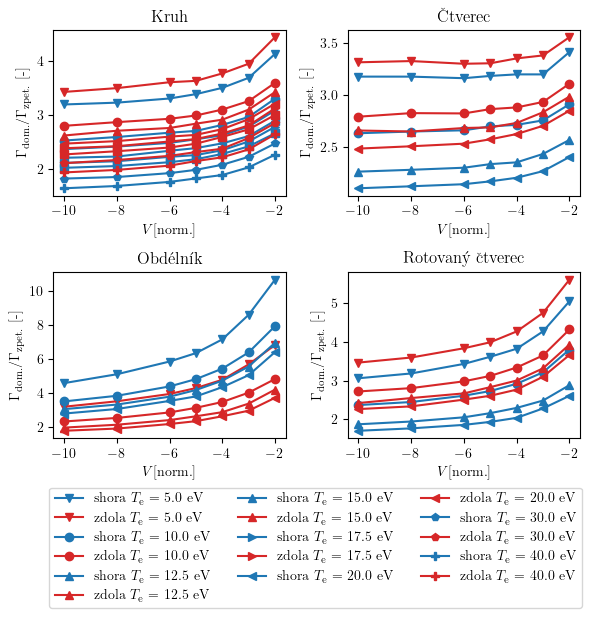

In [ ]:
def compare_upper_lower_one_AX(ax, df, title):
    for Te, i in zip(df['Te'].unique(), range(len(df['Te'].unique()))):
        ax.plot(pots, df[df['Te']==Te][df['pot'].isin(pots)]['Gu1'].values/df[df['Te']==Te][df['pot'].isin(pots)]['Gl1'].values,
                label=r'shora $T_\mathrm{e}$'+f' = {Te} eV', marker=markers[i], color='tab:blue', linestyle='solid')
        ax.plot(pots, df[df['Te']==Te][df['pot'].isin(pots)]['Gl3'].values/df[df['Te']==Te][df['pot'].isin(pots)]['Gu3'].values,
            label=r'zdola $T_\mathrm{e}$'+f' = {Te} eV', marker=markers[i], color='tab:red', linestyle='solid')
    ax.set_xlabel(r'$V[\mathrm{norm.}]$')
    ax.set_ylabel(r'$\Gamma_{\mathrm{dom.}}/\Gamma_{\mathrm{zpet.}}$ [-]')
    ax.set_title(title)

fig, axes = pp.subplots(2, 2, figsize=(6, 5))
compare_upper_lower_one_AX(axes[1,1], ULDFRS, "Rotovaný čtverec")
compare_upper_lower_one_AX(axes[0,0], ULDFC, "Kruh")
compare_upper_lower_one_AX(axes[0,1], ULDFS, "Čtverec")
compare_upper_lower_one_AX(axes[1,0], ULDFR, "Obdélník")

handles = []
labels = []
# Loop over subplots
for ax in axes.flatten():
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates while maintaining order
unique_legend = dict(zip(labels, handles))  # Dictionary preserves order from Python

# Add single figure-level legend
fig.legend(unique_legend.values(), unique_legend.keys(), bbox_to_anchor=(0.99, 0.028), ncol=3)


pp.tight_layout()
#pp.savefig('/home/jachym/Temporary/graph_export/RatioV.pgf', bbox_inches='tight', format='pgf')

/tmp/ipykernel_127044/1362624247.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/1362624247.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm1.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/1362624247.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2.sort_values('Voltage', inplace=True)
/tmp/ipykernel_127044/1362624247.py:23: SettingWithCopy

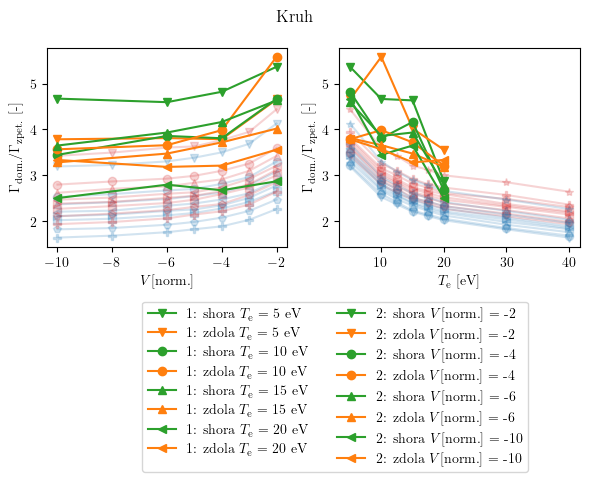

In [ ]:
def compare_upper_lower_one_AX(ax, df):
    for Te, i in zip(df['Te'].unique(), range(len(df['Te'].unique()))):
        ax.plot(pots, df[df['Te']==Te][df['pot'].isin(pots)]['Gu1'].values/df[df['Te']==Te][df['pot'].isin(pots)]['Gl1'].values,
                marker=markers[i], color='tab:blue', linestyle='solid', alpha=0.2)
        ax.plot(pots, df[df['Te']==Te][df['pot'].isin(pots)]['Gl3'].values/df[df['Te']==Te][df['pot'].isin(pots)]['Gu3'].values, 
                marker=markers[i], color='tab:red', linestyle='solid', alpha=0.2)
    ax.set_xlabel(r'$V[\mathrm{norm.}]$')
    ax.set_ylabel(r'$\Gamma_{\mathrm{dom.}}/\Gamma_{\mathrm{zpet.}}$ [-]')

def compare_widths_AX(ax, df, Tes):
    for Te, i in zip(Tes, range(len(Tes))):
        dfm2 = df[df['Te'].eq(Te) & df['Type'].eq(-2)]
        dfm1 = df[df['Te'].eq(Te) & df['Type'].eq(-1)]
        dfm2.sort_values('Voltage', inplace=True)
        dfm1.sort_values('Voltage', inplace=True)
        weightedm2 = np.array([weight_n(i) for i in dfm2['Width'].values])
        weightedm1 = np.array([weight_n(i) for i in dfm1['Width'].values])
        diff = weightedm1 - weightedm2
        ax.plot(dfm2['Voltage'], weightedm1/diff, label=r'1: shora $T_\mathrm{e}$'+f' = {Te} eV', marker=markers[i], color='tab:green', linestyle='solid')
        dfm2 = df[df['Te'].eq(Te) & df['Type'].eq(2)]
        dfm1 = df[df['Te'].eq(Te) & df['Type'].eq(1)]
        dfm2.sort_values('Voltage', inplace=True)
        dfm1.sort_values('Voltage', inplace=True)
        weightedm2 = np.array([weight_n(i) for i in dfm2['Width'].values])
        weightedm1 = np.array([weight_n(i) for i in dfm1['Width'].values])
        diff = weightedm1 - weightedm2
        ax.plot(dfm2['Voltage'], weightedm1/diff, label=r'1: zdola $T_\mathrm{e}$'+f' = {Te} eV', marker=markers[i], color='tab:orange', linestyle='solid')

def compare_upper_lower_Te_AX(ax, df):
    for pot, i in zip(df['pot'].unique(), range(len(df['pot'].unique()))):
        ax.plot(df[df['pot']==pot]['Te'], df[df['pot']==pot]['Gu1'].values/df[df['pot']==pot]['Gl1'].values,
                marker=markers[i], color='tab:blue', linestyle='solid', alpha=0.2)
        ax.plot(df[df['pot']==pot]['Te'], df[df['pot']==pot]['Gl3'].values/df[df['pot']==pot]['Gu3'].values,
                marker=markers[i], color='tab:red', linestyle='solid', alpha=0.2)
    ax.set_xlabel(r'$T_\mathrm{e}$ [eV]')
    ax.set_ylabel(r'$\Gamma_{\mathrm{dom.}}/\Gamma_{\mathrm{zpet.}}$ [-]')

def compare_widths_pot_AX(ax, df, pots):
    for pot, i in zip(pots, range(len(pots))):
        dfm2 = df[df['Voltage'].eq(pot) & df['Type'].eq(-2)]
        dfm1 = df[df['Voltage'].eq(pot) & df['Type'].eq(-1)]
        dfm2.sort_values('Te', inplace=True)
        dfm1.sort_values('Te', inplace=True)
        weightedm2 = np.array([weight_n(i) for i in dfm2['Width'].values])
        weightedm1 = np.array([weight_n(i) for i in dfm1['Width'].values])
        diff = weightedm1 - weightedm2
        ax.plot(dfm2['Te'], weightedm1/diff, label=r'2: shora $V[\mathrm{norm.}]$'+f' = {pot}', marker=markers[i], color='tab:green', linestyle='solid')
        dfm2 = df[df['Voltage'].eq(pot) & df['Type'].eq(2)]
        dfm1 = df[df['Voltage'].eq(pot) & df['Type'].eq(1)]
        dfm2.sort_values('Te', inplace=True)
        dfm1.sort_values('Te', inplace=True)
        weightedm2 = np.array([weight_n(i) for i in dfm2['Width'].values])
        weightedm1 = np.array([weight_n(i) for i in dfm1['Width'].values])
        diff = weightedm1 - weightedm2
        ax.plot(dfm2['Te'], weightedm1/diff, label=r'2: zdola $V[\mathrm{norm.}]$'+f' = {pot}', marker=markers[i], color='tab:orange', linestyle='solid')

fig, axes = pp.subplots(1, 2, figsize=(6, 3))
compare_upper_lower_one_AX(axes[0], ULDFC)
compare_widths_AX(axes[0], dfC, [5, 10, 15, 20])
compare_upper_lower_Te_AX(axes[1], ULDFC)
compare_widths_pot_AX(axes[1], dfC, [-2,-4,-6,-10])


handles = []
labels = []
# Loop over subplots
for ax in axes.flatten():
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates while maintaining order
unique_legend = dict(zip(labels, handles))  # Dictionary preserves order from Python

# Add single figure-level legend
fig.legend(unique_legend.values(), unique_legend.keys(), bbox_to_anchor=(0.9, 0.028), ncol=2)
fig.suptitle("Kruh")
pp.tight_layout()
#pp.savefig('/home/jachym/Temporary/graph_export/flowlinesMeasurement.pgf', bbox_inches='tight', format='pgf')

$$
\frac{I_{dom}}{I_{zpet}}  \propto  \frac{1}{|V|T_{e}}
$$

In [111]:
r = 0.00045 # m
SC = 2*np.pi*r
SR = 2.1*r*2
SS = (8*r)
SRS = 4*np.sqrt(2)*r
print(SC, SR, SS, SRS)

0.0028274333882308137 0.00189 0.0036 0.002545584412271571


In [112]:
def compare_shapes(df1, df2, S1, S2, plot_errorbars=False):
    smaller = []
    if len(df1['Te'].unique()) > len(df2['Te'].unique()):
        smaller = df2
    else:
        smaller = df1
    for Te, i in zip(smaller['Te'].unique(), range(len(smaller['Te'].unique()))):
        G11 = df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gu1'].values + df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gl1'].values
        G13 = df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gl3'].values + df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gu3'].values
        G21 = df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gu1'].values + df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gl1'].values
        G23 = df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gl3'].values + df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gu3'].values
        pp.plot(pots, G11/G21, label=f'shora Te = {Te}', marker=markers[i], color='tab:blue', linestyle=linestyles[0])
        pp.plot(pots, G13/G23, label=f'zespodu Te = {Te}', marker=markers[i], color='tab:red', linestyle=linestyles[0])
        if plot_errorbars: pp.errorbar(pots, G11/G21, yerr=(G11+0.14*G11)/(G21-0.14*G21), label=f'shora Te = {Te}', marker=markers[i], color='tab:blue', capsize=5, fmt='.')
        if plot_errorbars: pp.errorbar(pots, G13/G23, yerr=(G13+0.14*G13)/(G23-0.14*G23), label=f'zespodu Te = {Te}', marker=markers[i], color='tab:red', capsize=5, fmt='.')
        
        
        minus1 = lambda V, k, a: 1+k*(1/(V+a))
        coeff1, covar1 = so.curve_fit(minus1, pots, G11/G21)
        coeff3, covar3 = so.curve_fit(minus1, pots, G13/G23)
        pp.plot(np.linspace(np.min(pots)-1, 1, 100), minus1(np.linspace(np.min(pots)-1, 1, 100), *coeff1), color='tab:blue', linestyle=':')
        pp.plot(np.linspace(np.min(pots)-1, 1, 100), minus1(np.linspace(np.min(pots)-1, 1, 100), *coeff3), color='tab:red', linestyle=':')

        print(f'Pomer ploch: {S1/S2}')
        print(f'a1 = {coeff1[1]}, a3 = {coeff3[1]}')
        print(f'k1 = {coeff1[0]}, k3 = {coeff3[0]}')

    pp.legend(loc=(1.05, 0.1))
    pp.show()

Fituji pomocí:
$$
\frac{I_1}{I_2}(V) = \frac{k}{V+a}+1
$$

Pomer ploch: 1.4959965017094252
a1 = -237.97376430112115, a3 = -235.23756531863816
k1 = -80.20548975427822, k3 = -79.72099309840236
Pomer ploch: 1.4959965017094252
a1 = -111.47549360840968, a3 = -71.4256081216259
k1 = -42.158029611130225, k3 = -27.849804776145913
Pomer ploch: 1.4959965017094252
a1 = -75.44205913538711, a3 = -89.13026008955839
k1 = -27.247500855770628, k3 = -31.572274627196467
Pomer ploch: 1.4959965017094252
a1 = -69.80381578494823, a3 = -62.05809779683243
k1 = -25.57973169076128, k3 = -22.80913930854462


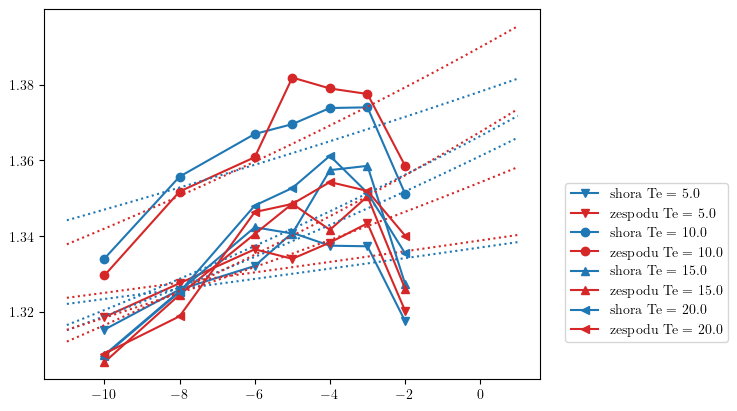

In [113]:
compare_shapes(ULDFC, ULDFR, SC, SR)

Pomer ploch: 1.2732395447351628
a1 = -28.589084340407823, a3 = -25.963284056037153
k1 = -4.60395601681353, k3 = -4.217311437422111
Pomer ploch: 1.2732395447351628
a1 = -15.19938189270719, a3 = -19.934118229742424
k1 = -2.4454700305663954, k3 = -3.0144513125281684
Pomer ploch: 1.2732395447351628
a1 = -13.025484949471894, a3 = -13.919042713447686
k1 = -2.5510302805141754, k3 = -2.725088814677541
Pomer ploch: 1.2732395447351628
a1 = -13.035962824901212, a3 = -13.441735823300029
k1 = -2.4276700877544912, k3 = -2.5395780041413296


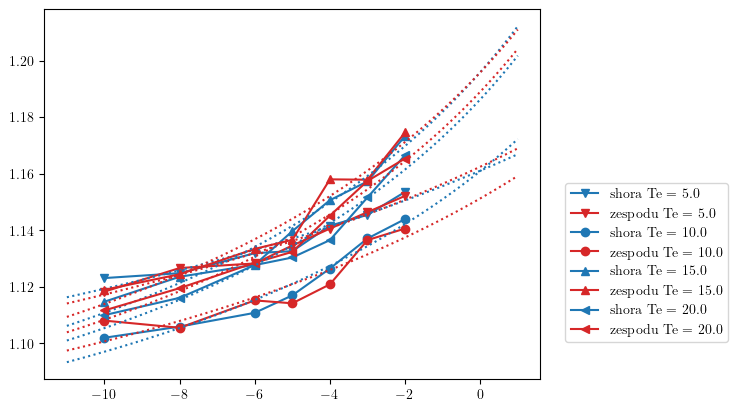

In [114]:
compare_shapes(ULDFS, ULDFC, SS, SC)

Pomer ploch: 1.1107207345395915
a1 = -33.92377206829116, a3 = -37.80543940929746
k1 = -6.701047792105357, k3 = -7.455950566380631
Pomer ploch: 1.1107207345395915
a1 = -25.09764812128836, a3 = -19.650556864452795
k1 = -5.512793590689143, k3 = -4.518392657418978
Pomer ploch: 1.1107207345395915
a1 = -19.497140962897312, a3 = -21.358537557131655
k1 = -4.132713281321086, k3 = -4.404548876472251
Pomer ploch: 1.1107207345395915
a1 = -14.869284331180019, a3 = -15.047207235402919
k1 = -3.4767030048420007, k3 = -3.4245365254417623


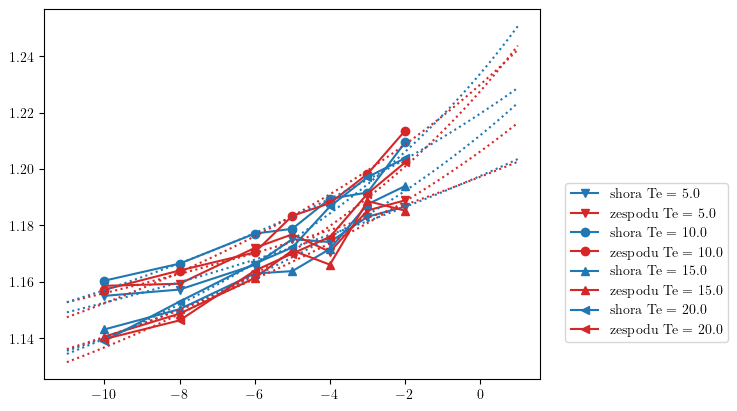

In [115]:
compare_shapes(ULDFC, ULDFRS, SC, SRS)

Pomer ploch: 1.1107207345395915
a1 = -33.92377206829116, a3 = -37.80543940929746
k1 = -6.701047792105357, k3 = -7.455950566380631
Pomer ploch: 1.1107207345395915
a1 = -25.09764812128836, a3 = -19.650556864452795
k1 = -5.512793590689143, k3 = -4.518392657418978
Pomer ploch: 1.1107207345395915
a1 = -19.497140962897312, a3 = -21.358537557131655
k1 = -4.132713281321086, k3 = -4.404548876472251
Pomer ploch: 1.1107207345395915
a1 = -14.869284331180019, a3 = -15.047207235402919
k1 = -3.4767030048420007, k3 = -3.4245365254417623


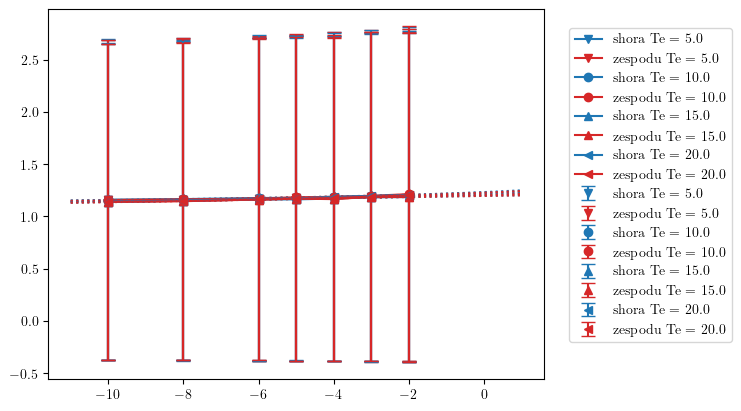

In [116]:
compare_shapes(ULDFC, ULDFRS, SC, SRS, plot_errorbars=True)

Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Computer Modern
Ignoring unknown font: Co

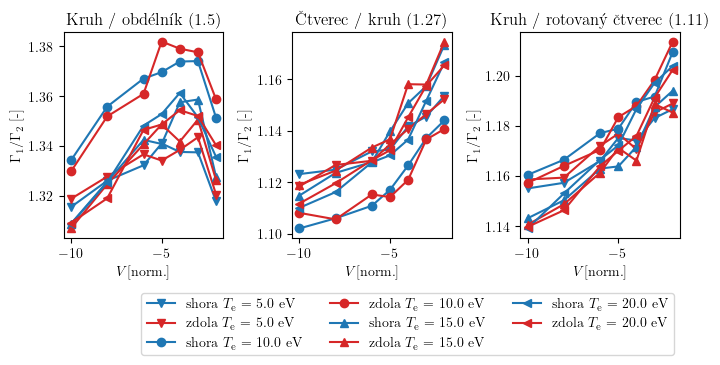

In [ ]:
def compare_shapes_AX(ax, df1, df2, S1, S2, title):
    smaller = []
    if len(df1['Te'].unique()) > len(df2['Te'].unique()):
        smaller = df2
    else:
        smaller = df1
    for Te, i in zip(smaller['Te'].unique(), range(len(smaller['Te'].unique()))):
        G11 = df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gu1'].values + df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gl1'].values
        G13 = df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gl3'].values + df1[df1['Te']==Te][df1['pot'].isin(pots)]['Gu3'].values
        G21 = df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gu1'].values + df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gl1'].values
        G23 = df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gl3'].values + df2[df2['Te']==Te][df2['pot'].isin(pots)]['Gu3'].values
        ax.plot(pots, G11/G21, label=r'shora $T_\mathrm{e}$'+f' = {Te} eV', marker=markers[i], color='tab:blue', linestyle=linestyles[0])
        ax.plot(pots, G13/G23, label=r'zdola $T_\mathrm{e}$'+f' = {Te} eV', marker=markers[i], color='tab:red', linestyle=linestyles[0])
    ax.set_title(title+f' ({round(S1/S2,2)})')
    ax.set_xlabel(r'$V[\mathrm{norm.}]$')
    ax.set_ylabel(r'$\Gamma_{1}/\Gamma_{2}$ [-]')

fig, axes = pp.subplots(1,3, figsize=(7,3))
compare_shapes_AX(axes[0], ULDFC, ULDFR, SC, SR, "Kruh / obdélník")
compare_shapes_AX(axes[1], ULDFS, ULDFC, SS, SC, "Čtverec / kruh")
compare_shapes_AX(axes[2], ULDFC, ULDFRS, SC, SRS, "Kruh / rotovaný čtverec")

handles = []
labels = []
# Loop over subplots
for ax in axes.flatten():
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates while maintaining order
unique_legend = dict(zip(labels, handles))  # Dictionary preserves order from Python

# Add single figure-level legend
fig.legend(unique_legend.values(), unique_legend.keys(), bbox_to_anchor=(0.98, 0.028), ncol=3)

pp.tight_layout()
#pp.savefig('/home/jachym/Temporary/graph_export/shapeComparison.pgf', bbox_inches='tight', format='pgf')